# 5. Sorting Fixed Length Lists without Heads

## Variable hyperparameters

In [ ]:
# Fixed length of list to be sorted
LIST_LENGTH = 5

# Size of vocabulary
D_VOCAB = 66

# Should lists have repetitions?
ALLOW_REPETITIONS = True

# Attention only? (False -> model includes MLPs)
ATTN_ONLY = True

# Model dimenions
N_LAYERS = 0
N_HEADS = 1
D_MODEL = 128
D_HEAD = 32
D_MLP = None

if ATTN_ONLY:
    D_MLP = None

# Default batch size
DEFAULT_BATCH_SIZE = 32

## Prelude

### Install and import

In [ ]:
try:
    import transformer_lens
except:
    !pip install git+https://github.com/neelnanda-io/TransformerLens
    !pip install circuitsvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens to /tmp/pip-req-build-ro7pdvgk
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-req-build-ro7pdvgk
  Resolved https://github.com/neelnanda-io/TransformerLens to commit 090f63afcf72e8ecd9527bbb6f598874554def1b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import repeat
import os
import pickle
import random
from typing import cast, Generator, Literal, List, Tuple, Dict

import circuitsvis as cv
from fancy_einsum import einsum
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from transformer_lens import HookedTransformerConfig, HookedTransformer
from tqdm import tqdm
from typing_extensions import Self

cv.examples.hello("You")

### Invariable hyperparameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

# Seeds to generate training, validation, and test data
TRAIN_SEED = 42
VAL_SEED = 66
TEST_SEED = 1729

# Context length: [start, *(unsorted_)list_length, mid, *(sorted_)list_length]
N_CTX = 2 * LIST_LENGTH + 2

# "Real" tokens range from 0 to D_VOCAB - 2 (non-inclusive)
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 2

# START token is D_VOCAB - 2 and MID token is D_VOCAB - 1
START_TOKEN_ID = VOCAB_MAX_ID
MID_TOKEN_ID = D_VOCAB - 1

DEVICE = 'cpu'


### Data generator and datasets

In [ ]:
def generate_list(batch_size: int) -> Tensor:
    if ALLOW_REPETITIONS:
        return torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (batch_size, LIST_LENGTH))
    return tensor([
        random.sample(range(VOCAB_MIN_ID, VOCAB_MAX_ID), k=LIST_LENGTH) 
        for _ in range(batch_size)
    ]).to(DEVICE)

# General generator
def make_data_gen(
    *,
    batch_size: int = DEFAULT_BATCH_SIZE,
    dataset: Literal["train", "val", "test"], # probably this arg needs a better name,
) -> Generator[Tensor, None, None]:
    assert dataset in ("train", "val", "test")
    if dataset == "train":
        seed = TRAIN_SEED
    elif dataset == "val":
        seed = VAL_SEED
    else: # test
        seed = TEST_SEED
    torch.manual_seed(seed)
    while True:
        # Generate random numbers
        x = generate_list(batch_size)
        # Sort
        x_sorted = torch.sort(x, dim=1).values
        # START tokens
        x_start = START_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        # MID tokens
        x_mid = MID_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        yield torch.cat((x_start, x, x_mid, x_sorted), dim=1)


# Training data generator (kinda wrapper)
def make_train_gen() -> Generator[Tensor, None, None]:
    """Make generator of training data"""
    return make_data_gen(batch_size=128, dataset="train")

# Validation and test data

val_data = next(make_data_gen(batch_size=1000, dataset="val"))
test_data = next(make_data_gen(batch_size=1000, dataset="test"))

### Loss function

In [ ]:
def loss_fn(
    logits: Tensor, # [batch, pos, d_vocab] 
    tokens: Tensor, # [batch, pos] 
    return_per_token: bool = False
) -> Tensor: # scalar
    """"""
    # 
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = tokens[:, sorted_start_pos : None]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

### Accuracy and validation

In [ ]:
def get_diff_row_inds(
    a: Tensor, # [dim1, dim2]
    b: Tensor  # [dim1, dim2]
) -> Tensor:   # [dim1]
    """Find indices of rows where a and b differ"""
    assert a.shape == b.shape
    return ((a == b).prod(dim=1) == 0).nonzero(as_tuple=True)[0]

def acc_fn(
    logits: Tensor, # [batch, pos, d_vocab]
    tokens: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Compute accuracy as percentage of correct predictions"""
    assert per in ("token", "sequence")
    sorted_start_pos = LIST_LENGTH + 2
    # Get logits of predictions for position
    logits = logits[:, (sorted_start_pos-1):-1]
    preds = logits.argmax(-1)
    tokens = tokens[:, sorted_start_pos:]
    if per == "sequence":
        return (preds == tokens).prod(dim=1).float().mean().item()
    return (preds == tokens).float().mean().item()

def validate(
    model: HookedTransformer, 
    data: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Test this model on `data`"""
    logits = model(data)
    acc = acc_fn(logits, tokens=data, per=per)
    return acc

def show_mispreds(
    model: HookedTransformer, 
    data: Tensor # [batch, pos]
) -> None:
    """Test this model on `data` and print mispredictions"""
    logits = model(data)
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = data[:, sorted_start_pos:]
    preds = logits.argmax(-1)
    mispred_inds = get_diff_row_inds(tokens, preds)
    for i in mispred_inds:
        print(f"[{i}] {tokens[i].numpy().tolist()} | {preds[i].numpy().tolist()}")
    print(f"{len(mispred_inds)}/{len(preds)} ({len(mispred_inds) / len(preds) :.2%})")

## Training

### Model

In [ ]:
def make_model() -> HookedTransformer:
    cfg = HookedTransformerConfig(
        d_model=D_MODEL,
        n_layers=N_LAYERS,
        n_heads=N_HEADS,
        d_head=D_HEAD,
        n_ctx=N_CTX,
        d_vocab=D_VOCAB,
        act_fn="relu",
        seed=42,
        device=DEVICE,
        attn_only=ATTN_ONLY
    )
    return HookedTransformer(cfg, move_to_device=True)

### Training setup

In [ ]:
@dataclass(frozen=True)
class TrainingHistory:
    losses: list[float]
    train_accuracies: list[float]
    val_accuracies: list[float]

def converged(val_accs: list[float], n_last: int = 10) -> bool:
    if len(val_accs) < n_last:
        return False
    return len(set(tensor(val_accs[-n_last:]).round(decimals=4).tolist())) == 1

def train_model(model: HookedTransformer, verbose: bool = True) -> TrainingHistory:
    # Number of epochs
    n_epochs = 20000

    # Optimization
    lr = 1e-3
    betas = (.9, .999)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=100)

    # Training data generator
    train_gen = make_train_gen()

    # Histories
    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        tokens = next(train_gen).to(device=DEVICE)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        optim.step()
        optim.zero_grad()
        scheduler.step(loss)
        
        if epoch % 100 == 0:
            losses.append(loss.item())
            train_batch_acc = acc_fn(logits, tokens, per="token")
            val_acc = validate(model, val_data, per="token")
            val_loss = loss_fn(model(val_data), val_data)

            train_accuracies.append(train_batch_acc)
            val_accuracies.append(val_acc)
            if verbose:
                print(
                    f"Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) : "
                    f"loss = {loss.item():.4f}; {train_batch_acc=:.3%}; "
                    f"{val_acc=:.3%}; lr={scheduler._last_lr[0]}" #type:ignore
                )
            # If last 10 recorded val_accuracies are 100%
            if converged(val_accuracies):
                if verbose:
                    print(f"\nAchieved consistent perfect validation accuracy after {epoch} epochs")
                break
    
    return TrainingHistory(losses, train_accuracies, val_accuracies)

def load_model_state(model: HookedTransformer, filename: str) -> None:
    assert os.path.isdir("models"), "Make a directory `models` with model state dicts"
    if not filename.startswith("models/"):
        filename = f"models/{filename}"
    with open(filename, "rb") as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

### Functions for updating global variables

In [ ]:
def set_globals(d_vocab: int, list_length: int, *, verbose: bool = True) -> None:
    global D_VOCAB, VOCAB_MAX_ID, START_TOKEN_ID, MID_TOKEN_ID, LIST_LENGTH, N_CTX
    D_VOCAB = d_vocab
    VOCAB_MAX_ID = START_TOKEN_ID = d_vocab - 2
    MID_TOKEN_ID = d_vocab - 1
    LIST_LENGTH = list_length
    N_CTX = 2 * LIST_LENGTH + 2
    if verbose:
        msg = "Globals " + ("reset" if d_vocab == 66 and list_length == 5 else "set") + " to"
        print(f"{msg}: {D_VOCAB = }, {LIST_LENGTH = }")

def reset_globals(*, verbose: bool = True) -> None:
    set_globals(d_vocab=66, list_length=5, verbose=verbose)

def update_data() -> None:
    global val_data, test_data
    val_data = next(make_data_gen(batch_size=1000, dataset="val"))
    test_data = next(make_data_gen(batch_size=1000, dataset="test"))

### Training or loading

In [ ]:
min_d_vocab = 20
max_d_vocab = 100
min_list_length = 2
max_list_length = 60
num = 10

reset_globals()

DVocab = ListLength = int
HyperparamTuple = Tuple[DVocab, ListLength]
hyperparam_tuples: List[HyperparamTuple] = []
for d_vocab in np.linspace(min_d_vocab, max_d_vocab, num=num, endpoint=False).astype(int):
    for list_length in np.linspace(min_list_length, max_list_length, num=num, endpoint=False).astype(int):
        if list_length < d_vocab - 2:
            hyperparam_tuples.append((d_vocab, list_length))

models: dict[HyperparamTuple, HookedTransformer] = {}
histories: dict[HyperparamTuple, TrainingHistory] = {}
for d_vocab, list_length in tqdm(hyperparam_tuples):
    set_globals(d_vocab=d_vocab, list_length=list_length, verbose=False)
    model = make_model()
    update_data()
    history = train_model(model, verbose=False)
    models[(d_vocab, list_length)] = model
    histories[(d_vocab, list_length)] = history

Globals reset to: D_VOCAB = 66, LIST_LENGTH = 5


100%|██████████| 80/80 [1:30:04<00:00, 67.55s/it] 


### Testing post-training

In [ ]:
print("Validating on validation data:")
val_acc = validate(model, val_data, per="token")
print(f"\t{val_acc=:.3%}\n")

print("\nValidating on test data:")
test_acc = validate(model, test_data, per="token")
print(f"\t{test_acc=:.3%}\n")

Validating on validation data:
	val_acc=34.954%


Validating on test data:
	test_acc=34.780%



### Saving and loading

In [ ]:
def make_timestamp() -> str:
    return dt.now().isoformat("T", "minutes").replace(":", "-")

In [ ]:
def save_histories(
    histories: dict[HyperparamTuple, TrainingHistory],
    filename: str | None = None
) -> None:
    filename = filename or f"2_histories_{make_timestamp()}.pkl"    
    with open(filename, "wb") as f:
        pickle.dump(histories, f)

def load_histories(filename: str) -> dict[HyperparamTuple, TrainingHistory]:
    with open(filename, "rb") as f:
        histories = pickle.load(f)
    return histories

save_histories(histories)

In [ ]:
from collections import OrderedDict

def save_model_state_dict(
    model: HookedTransformer, 
    filename: str | None = None
) -> None:
    filename = filename or f"model_state_dict_{make_timestamp()}.pkl"
    with open(filename, "wb") as f:
        pickle.dump(model.state_dict(), f)

def save_model_state_dicts(
    models: dict[HyperparamTuple, HookedTransformer], 
    filename: str | None = None
) -> None:
    state_dicts = {k: m.state_dict for k, m in models.items()}
    filename = filename or f"2_state_dicts_{make_timestamp()}.pkl"
    with open(filename, "wb") as f:
        pickle.dump(state_dicts, f)

def load_model_state_dicts(filename: str) -> dict[HyperparamTuple, OrderedDict]:
    with open(filename, "rb") as f:
        state_dicts: dict[HyperparamTuple, OrderedDict] = pickle.load(f)
    return state_dicts

def load_models(
    state_dicts_filename: str
) -> dict[HyperparamTuple, HookedTransformer]:
    state_dicts = load_model_state_dicts(filename=state_dicts_filename)
    models: dict[HyperparamTuple, HookedTransformer] = {}
    for (d_vocab, list_length), state_dict in state_dicts.items():
        set_globals(d_vocab=d_vocab, list_length=list_length, verbose=False)
        models[(d_vocab, list_length)] = make_model()
    return models

save_model_state_dicts(models)

## Investigate the model

### Accuracy heatmap

In [ ]:
vocab_sizes = np.linspace(min_d_vocab, max_d_vocab, num=num, endpoint=False).astype(int).tolist()
list_lengths = np.linspace(min_list_length, max_list_length, num=num, endpoint=False).astype(int).tolist()

final_val_accuracies = np.zeros((num, num))

for (d_vocab, list_length), model in tqdm(models.items()):
    set_globals(d_vocab=model.cfg.d_vocab, 
                list_length=model.cfg.n_ctx // 2 - 1,
                verbose=False)
    update_data()
    val_acc = validate(model, val_data, per="token")
    d_vocab_i = vocab_sizes.index(d_vocab)
    list_length_i = list_lengths.index(list_length)
    final_val_accuracies[d_vocab_i, list_length_i] = round(val_acc, 4)

100%|██████████| 80/80 [00:12<00:00,  6.20it/s]


In [ ]:
final_val_accuracies.round(2)

array([[0.11, 0.29, 0.41, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.07, 0.21, 0.33, 0.4 , 0.43, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.06, 0.18, 0.28, 0.35, 0.39, 0.42, 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.15, 0.25, 0.31, 0.36, 0.39, 0.41, 0.  , 0.  , 0.  ],
       [0.04, 0.13, 0.22, 0.28, 0.33, 0.36, 0.38, 0.4 , 0.42, 0.  ],
       [0.03, 0.1 , 0.18, 0.24, 0.29, 0.33, 0.36, 0.38, 0.4 , 0.42],
       [0.03, 0.1 , 0.17, 0.23, 0.27, 0.31, 0.33, 0.36, 0.38, 0.4 ],
       [0.02, 0.09, 0.15, 0.21, 0.25, 0.29, 0.31, 0.34, 0.36, 0.38],
       [0.02, 0.08, 0.14, 0.19, 0.24, 0.27, 0.3 , 0.32, 0.35, 0.36],
       [0.02, 0.08, 0.13, 0.17, 0.22, 0.25, 0.28, 0.31, 0.33, 0.35]])

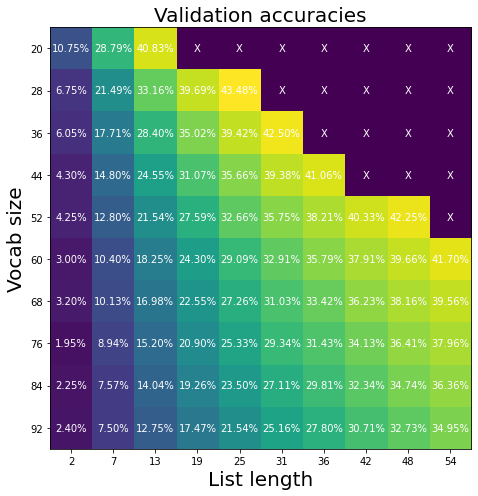

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(final_val_accuracies)
for x, list_length in enumerate(list_lengths):
    for y, d_vocab in enumerate(vocab_sizes):
        acc = f"{acc:.2%}" if (acc:=final_val_accuracies[y, x]) else "X"
        ax.text(x, y, acc, ha="center", va="center", color="w")
        
ax.set_xticks(range(num))
ax.set_xticklabels(list_lengths)
ax.set_yticks(range(num))
ax.set_yticklabels(vocab_sizes)
ax.set_title("Validation accuracies", fontsize=20)
ax.set_ylabel("Vocab size", fontsize=20)
ax.set_xlabel("List length", fontsize=20)

fig.tight_layout()
plt.show()

### Lookup table

Let's take the final model and look into its lookup table

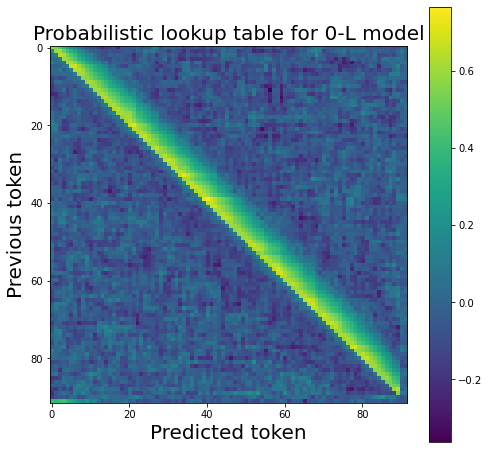

In [ ]:
def get_lookup_table(model: HookedTransformer) -> None:
    return (model.embed.W_E @ model.unembed.W_U).detach().numpy()

models_list = list(models.values())
lookup = get_lookup_table(models_list[-1])
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Probabilistic lookup table for 0-L model", fontsize=20)
ax.set_xlabel("Predicted token", fontsize=20)
ax.set_ylabel("Previous token", fontsize=20)
im = ax.imshow(lookup)
cbar = fig.colorbar(im)
fig.show()

And now for the smallest model

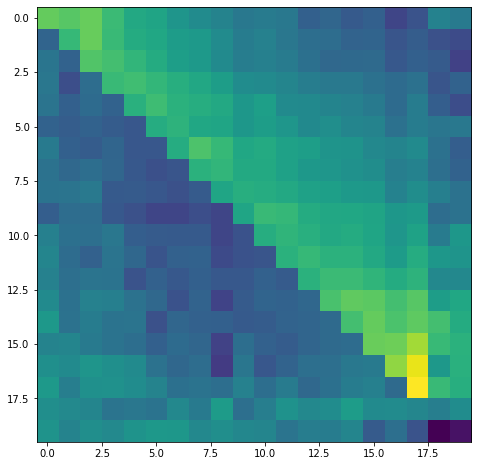

In [ ]:
lookup = get_lookup_table(models_list[0])
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(lookup)

Let's see concretely the probabilities it has for different tokens. We can see that any given token tends to assign the greatest probability to the one right after itself and probabilities decrease from that point onwards. Interestingly, probabilities almost never go below 0.01.

In [ ]:
from pprint import pprint
from torch.nn import functional as F

lookup = get_lookup_table(models_list[-1])
prev_token2next_token_probs = {
    prev_tok: dict(enumerate(tensor(next_tok_probs).softmax(-1).tolist())) 
    for prev_tok, next_tok_probs in enumerate(lookup)
}
# pprint(prev_token2next_token_probs)
prev_token2next_token_probs[83]

{0: 0.010656588710844517,
 1: 0.010729384608566761,
 2: 0.009018818847835064,
 3: 0.011183504946529865,
 4: 0.011383259668946266,
 5: 0.01110023818910122,
 6: 0.010574711486697197,
 7: 0.010403135791420937,
 8: 0.009565604850649834,
 9: 0.010081011801958084,
 10: 0.01067514717578888,
 11: 0.01024883333593607,
 12: 0.011930928565561771,
 13: 0.011180640198290348,
 14: 0.01067876722663641,
 15: 0.011703134514391422,
 16: 0.011569341644644737,
 17: 0.010627634823322296,
 18: 0.010096142999827862,
 19: 0.01015586219727993,
 20: 0.010429369285702705,
 21: 0.011005815118551254,
 22: 0.010746006853878498,
 23: 0.010073443874716759,
 24: 0.010575579479336739,
 25: 0.011708023957908154,
 26: 0.011868495494127274,
 27: 0.011178531683981419,
 28: 0.010549542494118214,
 29: 0.010276183485984802,
 30: 0.011867419816553593,
 31: 0.011355577036738396,
 32: 0.011035396717488766,
 33: 0.011128688231110573,
 34: 0.010044087655842304,
 35: 0.010853294283151627,
 36: 0.010667016729712486,
 37: 0.010648906

### Confirm this empirically on validation data

In [ ]:
model = models[(28, 25)]
set_globals(d_vocab=model.cfg.d_vocab, list_length=model.cfg.n_ctx // 2 - 1)
update_data()
logits = model(val_data)
list_length = model.cfg.n_ctx // 2 - 1
val_tokens = val_data[:, -list_length-1 : -1]
val_preds = logits[:, -list_length-1 : -1].argmax(-1)
assert val_tokens.shape == val_preds.shape, (f"{val_tokens.shape=}", f"{val_preds.shape=}")


Globals set to: D_VOCAB = 28, LIST_LENGTH = 25


In [ ]:
val_pred_counts = np.zeros((D_VOCAB, D_VOCAB))
for val_token in tqdm(val_tokens, "building val_pred_counts"):
    for val_pred in val_preds:
        val_pred_counts[val_token, val_pred] += 1

building val_pred_counts: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]


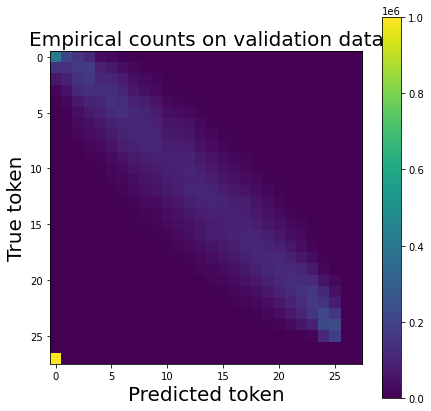

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.imshow(val_pred_counts)

ax.set_title("Empirical counts on validation data", fontsize=20)
ax.set_ylabel("True token", fontsize=20)
ax.set_xlabel("Predicted token", fontsize=20)
cbar = fig.colorbar(im)
fig.show()